In [43]:
# Read raw data from AWS S3

import io, os
import pandas as pd
from domino_data.data_sources import DataSourceClient


raw_filename = 'raw_cc_transactions.csv'
clean_filename = 'clean_cc_transactions.csv'
datasource_name = 'credit_card_fraud_detection'
domino_working_dir = os.environ.get("DOMINO_WORKING_DIR", ".")
domino_project_name = os.environ.get("DOMINO_PROJECT_NAME", "my-local-project")

domino_datasource_dir = domino_working_dir.replace('code', 'data')
domino_dataset_dir = f"{domino_datasource_dir}/{domino_project_name}"
domino_artifact_dir = domino_working_dir.replace('code', 'artifacts')

ds = DataSourceClient().get_datasource(datasource_name)
buf = io.BytesIO()
ds.download_fileobj(raw_filename, buf)
buf.seek(0)
raw_df = pd.read_csv(buf)
print(f"Loaded {len(raw_df):,} rows from {raw_filename}")

Loaded 78,324 rows from raw_cc_transactions.csv


In [44]:
# Remove dirty data

clean_df = raw_df.dropna()
rows_removed = len(raw_df) - len(clean_df)
pct_removed = 100 * rows_removed / len(raw_df)

print(f"🧹 Dropped {rows_removed:,} rows with missing data ({pct_removed:.2f}%)")

🧹 Dropped 1,114 rows with missing data (1.42%)


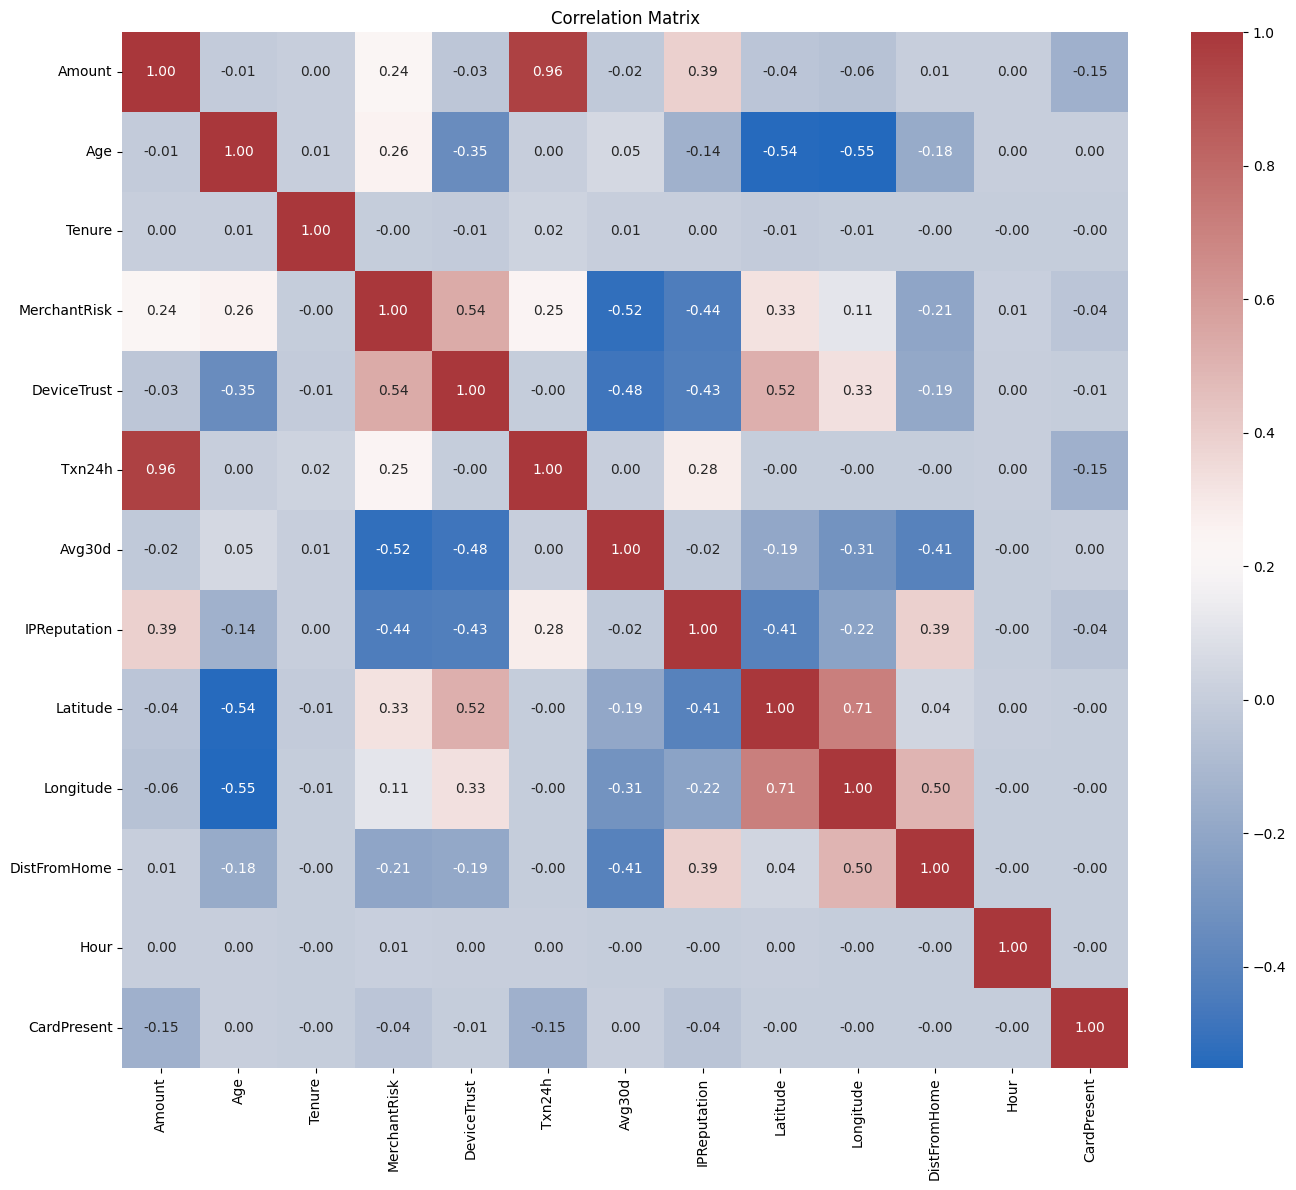

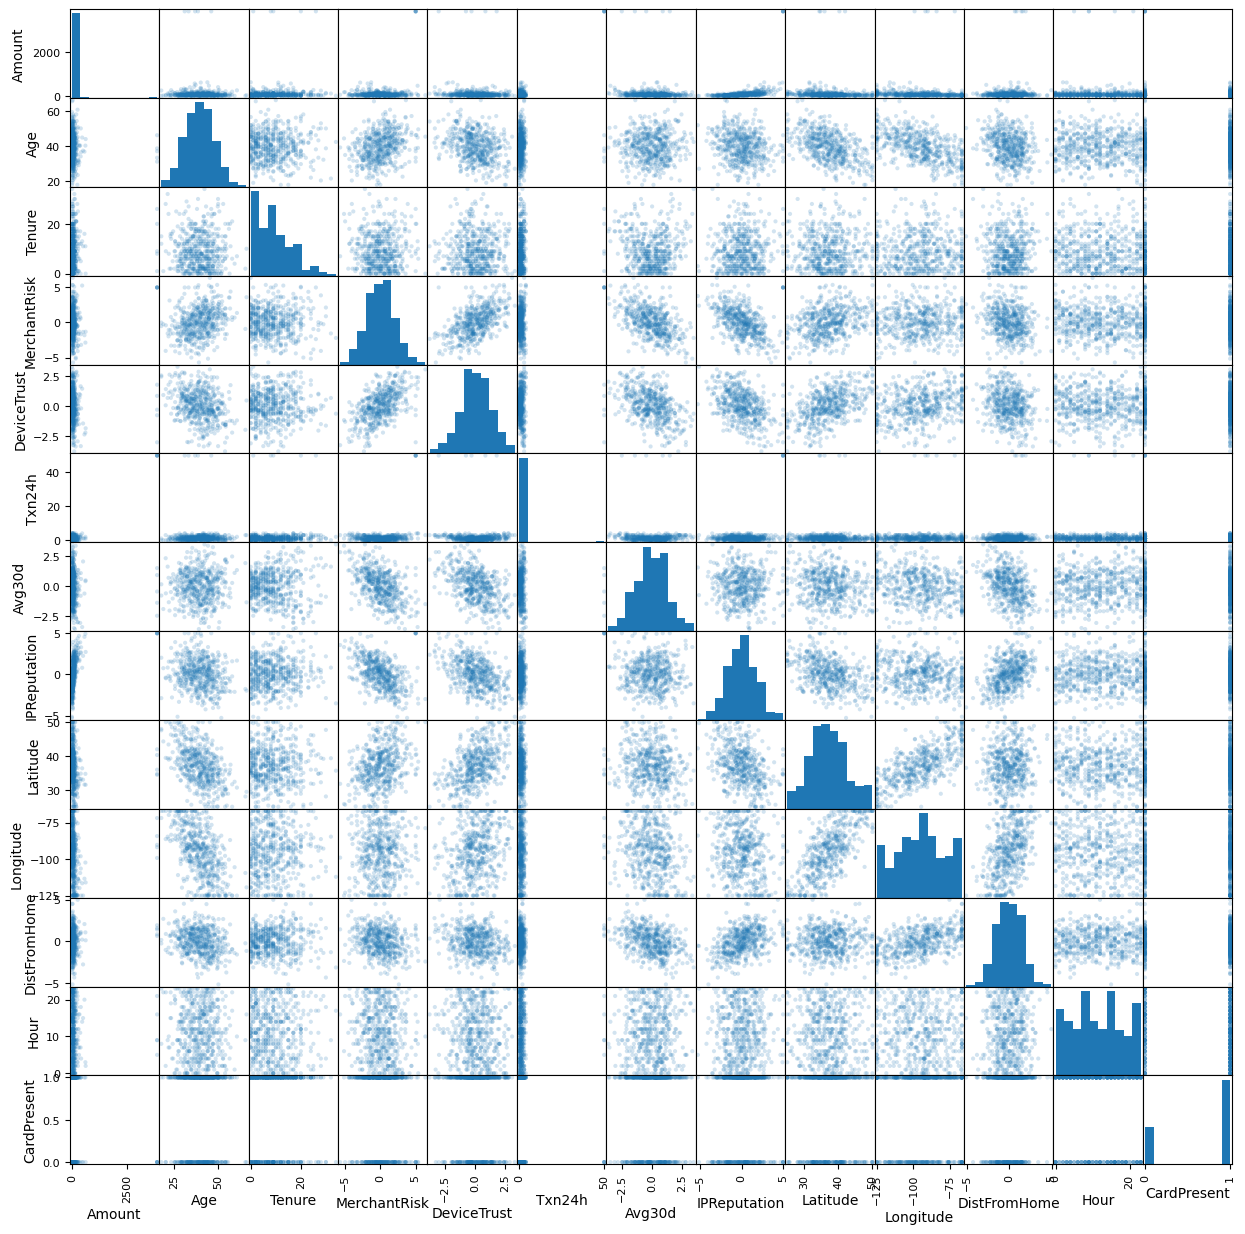

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 19/19 [00:00<00:00, 27.18it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Generated and saved plots and report


In [45]:
# Generate plots and report
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
from ydata_profiling import ProfileReport

num_df = df.select_dtypes(include="number").drop(columns=["Time", "Class"], errors="ignore")

# Correlation heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(num_df.corr(), annot=True, fmt=".2f", cmap="vlag")
plt.title("Correlation Matrix")
plt.tight_layout()

corr_path = str(f"{domino_artifact_dir}/raw_correlation_matrix.png")
plt.savefig(corr_path, dpi=300, bbox_inches='tight')
plt.show()

# Scatter matrix (sampled for performance)
sample_size = min(500, len(num_df))
sample_df = num_df.sample(n=sample_size, random_state=42)

fig = scatter_matrix(sample_df, alpha=0.2, diagonal="hist", figsize=(15, 15))
scatter_path = str(f"{domino_artifact_dir}/raw_scatter_plots.png")
plt.savefig(scatter_path, dpi=300, bbox_inches='tight')
plt.show()

# HTML Exploritory Data Analysis (EDA) Report
profile = ProfileReport(
    df, 
    title="Credit Card Fraud Detection - EDA Report",
    explorative=True,
    minimal=True
)

eda_path = str(f"{domino_artifact_dir}/preprocessing_report.html")
profile.to_file(eda_path)
profile.to_notebook_iframe()

print(f"Generated and saved plots and report")

In [46]:
# Save cleaned dataframe to Domino Dataset

clean_df.to_csv(f"{domino_dataset_dir}/{clean_filename}")